# PSD

author: steeve.laquitaine@epfl.ch

last modified: 24.10.2024

## Setup

1. Setup `spikeinterf..` virtual environment

2. Compute the power spectral densities of the entire recordings (multi-nodes multi-core, 10m): 

    sbatch cluster/validation/psd/mpi_npx_full.sh  
    sbatch cluster/validation/psd/mpi_dense_full.sh

In [50]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import copy
import multiprocessing
import torch
import seaborn as sns
import pandas as pd
from scipy.stats import kruskal # stats
import scikit_posthocs as sp

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)


from src.nodes import utils
from src.nodes.utils import get_config, get_stats_config, standardize_layers
from src.nodes.validation import power

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
prm = dict()
prm["SFREQ_HV"] = 20000          # sampling frequency
prm["SFREQ_HS"] = 20000        # sampling frequency
prm["SFREQ_NV"] = 30000          # sampling frequency
prm["SFREQ_NS"] = 40000        # sampling frequency
prm["SFREQ_NB"] = 32000
prm["SFREQ_NE"] = 20000

# SETUP DATASETS

# neuropixels *********************

# neuropixels (Marques-Smith)
cfg_nv, _ = get_config("vivo_marques", "c26").values() 
RAW_PATH_nv = cfg_nv["probe_wiring"]["full"]["output"]
PREP_PATH_nv = cfg_nv["preprocessing"]["full"]["output"]["trace_file_path"]
PRE_PSD_PATH_NV = cfg_nv["validation"]["psd"]["preprocessed"]

# neuropixels (biophy. spont.)
cfg_ns, param_conf_ns = get_config("silico_neuropixels", "npx_spont").values()
RAW_PATH_ns = cfg_ns["probe_wiring"]["full"]["output"]
PREP_PATH_ns = cfg_ns["preprocessing"]["full"]["output"]["trace_file_path"]
PRE_PSD_PATH_NS = cfg_ns["validation"]["psd"]["preprocessed"]

# neuropixels (evoked biophy.)
cfg_ne, _ = get_config("silico_neuropixels", "npx_evoked").values()
RAW_PATH_ne = cfg_ne["probe_wiring"]["full"]["output"]
PRE_PATH_NE = cfg_ne["preprocessing"]["full"]["output"]["trace_file_path"]
PRE_PSD_PATH_NE = cfg_ne["validation"]["psd"]["preprocessed"]

# neuropixels (synthetic, Buccino)
cfg_nb, param_conf_nb = get_config("buccino_2020", "2020").values()
PRE_PSD_PATH_NB = cfg_nb["validation"]["psd"]["preprocessed"]

# custom *******************
# vivo (probe 1)
cfg_hv1, _ = get_config("vivo_horvath", "probe_1").values()
RAW_PATH_hv1 =  cfg_hv1["probe_wiring"]["full"]["output"]
PREP_PATH_hv1 = cfg_hv1["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV1 = cfg_hv1["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV1 = cfg_hv1["validation"]["psd"]["preprocessed"]
# probe 2
cfg_hv2, _ = get_config("vivo_horvath", "probe_2").values()
RAW_PATH_hv2 =  cfg_hv2["probe_wiring"]["full"]["output"]
PREP_PATH_hv2 = cfg_hv2["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV2 = cfg_hv2["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV2 = cfg_hv2["validation"]["psd"]["preprocessed"]
# probe 3
cfg_hv3, _ = get_config("vivo_horvath", "probe_3").values()
RAW_PATH_hv3 =  cfg_hv3["probe_wiring"]["full"]["output"]
PREP_PATH_hv3 = cfg_hv3["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV3 = cfg_hv3["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV3 = cfg_hv3["validation"]["psd"]["preprocessed"]
# biophy. model
# (probe 1)
cfg_hs1, _ = get_config("dense_spont", "probe_1").values()
RAW_PATH_hs1 = cfg_hs1["probe_wiring"]["full"]["output"]
PREP_PATH_hs1 = cfg_hs1["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS1 = cfg_hs1["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS1 = cfg_hs1["validation"]["psd"]["preprocessed"]
# probe 2
cfg_hs2, _ = get_config("dense_spont", "probe_2").values()
RAW_PATH_hs2 = cfg_hs2["probe_wiring"]["full"]["output"]
PREP_PATH_hs2 = cfg_hs2["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS2 = cfg_hs2["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS2 = cfg_hs2["validation"]["psd"]["preprocessed"]
# probe 3
cfg_hs3, _ = get_config("dense_spont", "probe_3").values()
RAW_PATH_hs3 = cfg_hs3["probe_wiring"]["full"]["output"]
PREP_PATH_hs3 = cfg_hs3["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS3 = cfg_hs3["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS3 = cfg_hs3["validation"]["psd"]["preprocessed"]

# pipeline parameters
SAVE_FIG = False
SAVE_TEMP_DATA = False
LOAD_TEMP_DATA = True

PLOT_DATA_PATH_NPX = get_stats_config()["fig2s_data_APpower_npx"]
PLOT_DATA_PATH_DENSE = get_stats_config()["fig2u_data_APpower_dense"]

# FIGURE SETTINGS
FIG_SIZE = (1.5, 1.5)
# experiment colors
cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_MEDIAN"] = (1, 0.76, 0)
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes aesthetics
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-12-10 17:07:22,653 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-10 17:07:22,689 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-10 17:07:22,690 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-10 17:07:22,725 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-10 17:07:22,726 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-10 17:07:22,787 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-10 17:07:22,788 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-10 17:07:22,815 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-10 17:07:22,816 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-10 17:07:22,836 - root - utils.py - get_config - INFO - R

## Specs

## (1s)Load datasets

* select first 10 min for speed

In [4]:
# Load traces
# neuropixels
# raw
RawNV = si.load_extractor(RAW_PATH_nv)
RawNS = si.load_extractor(RAW_PATH_ns)
RawNE = si.load_extractor(RAW_PATH_ne)
# preprocessed
PrepNV = si.load_extractor(PREP_PATH_nv)

# Dense probe
# raw (probe 1, 2, 3)
RawHV1 = si.load_extractor(RAW_PATH_hv1)
RawHS1 = si.load_extractor(RAW_PATH_hs1)
RawHV2 = si.load_extractor(RAW_PATH_hv2)
RawHS2 = si.load_extractor(RAW_PATH_hs2)
RawHV3 = si.load_extractor(RAW_PATH_hv3)
RawHS3 = si.load_extractor(RAW_PATH_hs3)
# preprocessed (probe 1, 2, 3)
PrepHV1 = si.load_extractor(PREP_PATH_hv1)
PrepHS1 = si.load_extractor(PREP_PATH_hs1)
PrepHV2 = si.load_extractor(PREP_PATH_hv2)
PrepHS2 = si.load_extractor(PREP_PATH_hs2)
PrepHV3 = si.load_extractor(PREP_PATH_hv3)
PrepHS3 = si.load_extractor(PREP_PATH_hs3)


# 4 - get good sites (in cortex) **********************
# neuropixels
lyrs = ["L1", "L2_3", "L4", "L5", "L6"]
# silico
site_ly_ns = RawNS.get_property("layers")
site_ly_ns[site_ly_ns == "L2"] = "L2_3"
site_ly_ns[site_ly_ns == "L3"] = "L2_3"
sites_ns = np.where(np.isin(site_ly_ns, lyrs))[0]
# evoked
site_ly_ne = RawNE.get_property("layers")
site_ly_ne[site_ly_ne == "L2"] = "L2_3"
site_ly_ne[site_ly_ne == "L3"] = "L2_3"
sites_ne = np.where(np.isin(site_ly_ne, lyrs))[0]
# vivo
site_ly_nv = RawNV.get_property("layers")
sites_nv = np.where(np.isin(site_ly_nv, lyrs))[0]

# horvath
# silico
# probe 1 (select L1, L2/3)
site_ly_hs1 = RawHS1.get_property("layers")
site_ly_hs1 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs1])
sites_hs1 = np.where(np.isin(site_ly_hs1, ["L1", "L2_3"]))[0]
# probe 2 (select L4 and L5)
site_ly_hs2 = RawHS2.get_property("layers")
sites_hs2 = np.where(np.isin(site_ly_hs2, ["L4", "L5"]))[0]
# probe 3 (select L6)
site_ly_hs3 = RawHS3.get_property("layers")
site_ly_hs3 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs3])
sites_hs3 = np.where(np.isin(site_ly_hs3, ["L6"]))[0]

# vivo
# probe 1
site_ly_hv1 = RawHV1.get_property("layers")
sites_hv1 = np.where(np.isin(site_ly_hv1, ["L1", "L2_3"]))[0]
# probe 2
site_ly_hv2 = RawHV2.get_property("layers")
sites_hv2 = np.where(np.isin(site_ly_hv2, ["L4", "L5"]))[0]
# probe 3
site_ly_hv3 = RawHV3.get_property("layers")
sites_hv3 = np.where(np.isin(site_ly_hv3, ["L6"]))[0]

# Load pre-computed PSDs (in cortex)
# neuropixels
# preprocessed
psd_pre_nv = np.load(PRE_PSD_PATH_NV, allow_pickle=True).item()
psd_pre_ns = np.load(PRE_PSD_PATH_NS, allow_pickle=True).item()
psd_pre_ne = np.load(PRE_PSD_PATH_NE, allow_pickle=True).item()
psd_pre_nb = np.load(PRE_PSD_PATH_NB, allow_pickle=True).item()
# preprocessed
psd_pre_hv1 = np.load(PRE_PSD_PATH_HV1, allow_pickle=True).item()
psd_pre_hv2 = np.load(PRE_PSD_PATH_HV2, allow_pickle=True).item()
psd_pre_hv3 = np.load(PRE_PSD_PATH_HV3, allow_pickle=True).item()
psd_pre_hs1 = np.load(PRE_PSD_PATH_HS1, allow_pickle=True).item()
psd_pre_hs2 = np.load(PRE_PSD_PATH_HS2, allow_pickle=True).item()
psd_pre_hs3 = np.load(PRE_PSD_PATH_HS3, allow_pickle=True).item()

# unit-test
assert psd_pre_hv1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_nv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ns["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ne["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_nb["freq"][1] == 1.0, "psd resolution should be 1Hz"

## (2s)AP power (NPX)

* power in the frequency band of the action potential (300 - 1000 Hz (a period of 1ms to 3 ms)

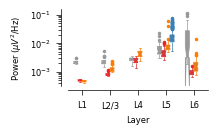

In [ ]:
FIG_SIZE = (1.8, 1)

NORM = False

# calculate stats and plot data
d1 = power.get_psd_data_prepro(
    "L1",
    psd_pre_hv1,
    psd_pre_hs1,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv1[sites_hv1],
    site_ly_hs1[sites_hs1],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
    norm=NORM,
)
d23 = power.get_psd_data_prepro(
    "L2_3",
    psd_pre_hv1,
    psd_pre_hs1,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv1[sites_hv1],
    site_ly_hs1[sites_hs1],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
    norm=NORM,
)
d4 = power.get_psd_data_prepro(
    "L4",
    psd_pre_hv2,  # probe 2
    psd_pre_hs2,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv2[sites_hv2],  # probe 2
    site_ly_hs2[sites_hs2],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
    norm=NORM,
)
d5 = power.get_psd_data_prepro_layer_5(
    "L5",
    psd_pre_hv2,  # probe 2
    psd_pre_hs2,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    psd_pre_nb,
    site_ly_hv2[sites_hv2],  # probe 2
    site_ly_hs2[sites_hs2],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
    norm=NORM,
)
d6 = power.get_psd_data_prepro(
    "L6",
    psd_pre_hv3,  # probe 3
    psd_pre_hs3,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv3[sites_hv3],  # probe 3
    site_ly_hs3[sites_hs3],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
    norm=NORM,
)

c_bot = 300  # spike with a period of 3 ms
c_up = 1000  # spike with a period of 0.5 ms

# Marques-Smith
df_nv1 = power.get_spiking_power(d1["psd_pre_nv_"], c_bot, c_up, "M", "L1")
df_nv23 = power.get_spiking_power(d23["psd_pre_nv_"], c_bot, c_up, "M", "L2_3")
df_nv4 = power.get_spiking_power(d4["psd_pre_nv_"], c_bot, c_up, "M", "L4")
df_nv5 = power.get_spiking_power(d5["psd_pre_nv_"], c_bot, c_up, "M", "L5")
df_nv6 = power.get_spiking_power(d6["psd_pre_nv_"], c_bot, c_up, "M", "L6")

# npx spontaneous
df_ns1 = power.get_spiking_power(d1["psd_pre_ns_"], c_bot, c_up, "NS", "L1")
df_ns23 = power.get_spiking_power(d23["psd_pre_ns_"], c_bot, c_up, "NS", "L2_3")
df_ns4 = power.get_spiking_power(d4["psd_pre_ns_"], c_bot, c_up, "NS", "L4")
df_ns5 = power.get_spiking_power(d5["psd_pre_ns_"], c_bot, c_up, "NS", "L5")
df_ns6 = power.get_spiking_power(d6["psd_pre_ns_"], c_bot, c_up, "NS", "L6")

# evoked
df_ne1 = power.get_spiking_power(d1["psd_pre_ne_"], c_bot, c_up, "E", "L1")
df_ne23 = power.get_spiking_power(d23["psd_pre_ne_"], c_bot, c_up, "E", "L2_3")
df_ne4 = power.get_spiking_power(d4["psd_pre_ne_"], c_bot, c_up, "E", "L4")
df_ne5 = power.get_spiking_power(d5["psd_pre_ne_"], c_bot, c_up, "E", "L5")
df_ne6 = power.get_spiking_power(d6["psd_pre_ne_"], c_bot, c_up, "E", "L6")

# synthetic
df_s5 = power.get_spiking_power(d5["psd_pre_nb_"], c_bot, c_up, "S", "L5")

# stack
plot_df_npx = pd.concat(
    [
        df_nv1,
        df_nv23,
        df_nv4,
        df_nv5,
        df_nv6,
        df_ns1,
        df_ns23,
        df_ns4,
        df_ns5,
        df_ns6,
        df_ne1,
        df_ne23,
        df_ne4,
        df_ne5,
        df_ne6,
        df_s5,
    ]
)

# standardize
plot_df_npx["Layer"][plot_df_npx["Layer"] == "L2_3"] = "L2/3"

# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax = sns.boxplot(
    ax=ax,
    data=plot_df_npx,
    x="Layer",
    y="power",
    hue="Experiment",
    notch=True,
    hue_order=["M", "NS", "E", "S"],
    palette=[cl["COLOR_NV"], cl["COLOR_NS"], cl["COLOR_NE"], cl["COLOR_NB"]],
    width=0.6,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)
ax.set_yscale("log")

# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# minor ticks
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=np.arange(0, 1.1, 0.1),
    numticks=5,
)
ax.tick_params(which="both")
ax.yaxis.set_minor_locator(locmin)

# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            box.set_edgecolor(cl["COLOR_NV"])
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (NV)
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_NV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_NV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (NS)
            box.set_edgecolor(cl["COLOR_NS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NS"])
                ax.lines[k].set_mfc(cl["COLOR_NS"])
                ax.lines[k].set_mec(cl["COLOR_NS"])
            p += 1
        elif p in [10, 11, 12, 13, 14]:
            box.set_edgecolor(cl["COLOR_NE"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NE"])
                ax.lines[k].set_mfc(cl["COLOR_NE"])
                ax.lines[k].set_mec(cl["COLOR_NE"])
            p += 1
        elif p in [15]:
            box.set_edgecolor(cl["COLOR_NB"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NB"])
                ax.lines[k].set_mfc(cl["COLOR_NB"])
                ax.lines[k].set_mec(cl["COLOR_NB"])
            p += 1

# legend
ax.set_ylabel("Power ($\u03bcV^2$/Hz)")
ax.set_xlabel("Layer")

# save
if SAVE_FIG:
    plt.savefig("figures/0_validation/4_power/fig2S/AP_power_npx.svg", **savefig_cfg)

### SAVE TEMP DATA

In [51]:
# save plot and statistics data
if SAVE_TEMP_DATA:
    plot_df_npx.to_parquet(PLOT_DATA_PATH_NPX)
    print("Saved here:", PLOT_DATA_PATH_NPX)
elif LOAD_TEMP_DATA:
    plot_df_npx = pd.read_parquet(PLOT_DATA_PATH_NPX)

## (1s)AP power (dense probe)

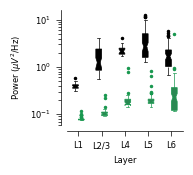

In [13]:
# Marques-Smith
df_hv1 = power.get_spiking_power(d1["psd_pre_hv_"], c_bot, c_up, "H", "L1")
df_hv23 = power.get_spiking_power(d23["psd_pre_hv_"], c_bot, c_up, "H", "L2_3")
df_hv4 = power.get_spiking_power(d4["psd_pre_hv_"], c_bot, c_up, "H", "L4")
df_hv5 = power.get_spiking_power(d5["psd_pre_hv_"], c_bot, c_up, "H", "L5")
df_hv6 = power.get_spiking_power(d6["psd_pre_hv_"], c_bot, c_up, "H", "L6")

# npx spontaneous
df_hs1 = power.get_spiking_power(d1["psd_pre_hs_"], c_bot, c_up, "DS", "L1")
df_hs23 = power.get_spiking_power(d23["psd_pre_hs_"], c_bot, c_up, "DS", "L2_3")
df_hs4 = power.get_spiking_power(d4["psd_pre_hs_"], c_bot, c_up, "DS", "L4")
df_hs5 = power.get_spiking_power(d5["psd_pre_hs_"], c_bot, c_up, "DS", "L5")
df_hs6 = power.get_spiking_power(d6["psd_pre_hs_"], c_bot, c_up, "DS", "L6")

# stack
plot_df_dense = pd.concat(
    [
        df_hv1,
        df_hv23,
        df_hv4,
        df_hv5,
        df_hv6,
        df_hs1,
        df_hs23,
        df_hs4,
        df_hs5,
        df_hs6,
    ]
)

# standardize
plot_df_dense["Layer"][plot_df_dense["Layer"] == "L2_3"] = "L2/3"

# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax = sns.boxplot(
    ax=ax,
    data=plot_df_dense,
    x="Layer",
    y="power",
    hue="Experiment",
    notch=True,
    hue_order=["H", "DS"],
    palette=[cl["COLOR_HV"], cl["COLOR_HS"]],
    width=0.5,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)
ax.set_yscale("log")

# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# minor ticks
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=np.arange(0, 1.1, 0.1),
    numticks=10,
)
ax.tick_params(which="both")
ax.yaxis.set_minor_locator(locmin)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# ax.legend("", frameon=False)
ax.set_ylabel("Power ($\u03bcV^2$/Hz)")
ax.set_xlabel("Layer")
# ax.set_ylim([1.4, 3.7])


# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (NV)
            box.set_edgecolor(cl["COLOR_HV"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_HV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_HV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (DS)
            box.set_edgecolor(cl["COLOR_HS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HS"])
                ax.lines[k].set_mfc(cl["COLOR_HS"])
                ax.lines[k].set_mec(cl["COLOR_HS"])
            p += 1

# save
if SAVE_FIG:
    plt.savefig(
        "figures/0_validation/4_power/fig2U/fig2U_AP_power_dense.svg", **savefig_cfg
    )

### SAVE TEMP data

In [52]:
# save plot and statistics data
if SAVE_TEMP_DATA:
    plot_df_dense.to_parquet(PLOT_DATA_PATH_DENSE)
    print("Saved here:", PLOT_DATA_PATH_DENSE)
elif LOAD_TEMP_DATA:
    plot_df_dense = pd.read_parquet(PLOT_DATA_PATH_DENSE)

### Hypothesis testing

In [ ]:
def get_power(df, exp, layer):
    return df[(df.Experiment == exp) & (df.Layer == layer)]["power"].values


def get_kk(df, exp):
    """kruskall wallis test"""
    h, p = kruskal(
        get_power(df, exp, "L1"),
        get_power(df, exp, "L2/3"),
        get_power(df, exp, "L4"),
        get_power(df, exp, "L5"),
        get_power(df, exp, "L6"),
    )

    print(f"H={h}, p={p}")
    print(f"""N_L1 = {len(get_power(df, exp, "L1"))} sites""")
    print(f"""N_L23 = {len(get_power(df, exp, "L2/3"))} sites""")
    print(f"""N_L4 = {len(get_power(df, exp, "L4"))} sites""")
    print(f"""N_L5 = {len(get_power(df, exp, "L5"))} sites""")
    print(f"""N_L6 = {len(get_power(df, exp, "L6"))} sites""")


def get_posthoc_dunn_holm_sidak(df, exp):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        df (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_power(df, exp, "L1"),
        get_power(df, exp, "L2/3"),
        get_power(df, exp, "L4"),
        get_power(df, exp, "L5"),
        get_power(df, exp, "L6"),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["L1", "L2/3", "L4", "L5", "L6"]
    df.index = ["L1", "L2/3", "L4", "L5", "L6"]
    return df

def ci95(data):
    return 1.96 * np.nanstd(data) / np.sqrt(np.sum(~np.isnan(data)))

def get_medians_and_ci95(plot_data, exp, feature: str):
    layers = ["L1", "L2/3", "L4", "L5", "L6"]
    stats = ""
    record = []
    for layer in layers:
        feature_data = plot_data[(plot_data.Experiment==exp) & (plot_data.Layer==layer)][feature]
        stats += f"{np.round(feature_data.median()*10000)/10000} $\pm$ {np.round(ci95(feature_data),6)}, "
        record.append(np.round(feature_data.median()*10000)/10000)
    print(stats)
    return record

### Power changes across layers?

NPX

In [59]:
print("\n--------------------MS--------------------\n")
get_kk(plot_df_npx, "M")
display(get_posthoc_dunn_holm_sidak(plot_df_npx, "M"))
m_m = get_medians_and_ci95(plot_df_npx, "M", "power") 

print("\n--------------------NS--------------------\n")
get_kk(plot_df_npx, "NS")
display(get_posthoc_dunn_holm_sidak(plot_df_npx, "NS"))
m_ns = get_medians_and_ci95(plot_df_npx, "NS", "power") 

print("\n--------------------E--------------------\n")
get_kk(plot_df_npx, "E")
display(get_posthoc_dunn_holm_sidak(plot_df_npx, "E"))
m_e = get_medians_and_ci95(plot_df_npx, "E", "power") 

print("\n--------------------S--------------------\n")
m_s =get_medians_and_ci95(plot_df_npx, "S", "power") 


--------------------MS--------------------

H=129.92523257168455, p=4.040099767668325e-27
N_L1 = 10 sites
N_L23 = 42 sites
N_L4 = 34 sites
N_L5 = 42 sites
N_L6 = 98 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,9.401085e-01,3.662062e-01,7.899339e-07,1.511354e-06
L2/3,9.401085e-01,1.000000e+00,1.117843e-01,4.488586e-16,1.123281e-18
L4,3.662062e-01,1.117843e-01,1.000000e+00,6.154217e-08,3.234225e-08
L5,7.899339e-07,4.488586e-16,6.154217e-08,1.000000e+00,6.361670e-01
L6,1.511354e-06,1.123281e-18,3.234225e-08,6.361670e-01,1.000000e+00


0.002 $\pm$ 0.00025, 0.0022 $\pm$ 0.000199, 0.0028 $\pm$ 0.000141, 0.0052 $\pm$ 0.001176, 0.004 $\pm$ 0.004328, 

--------------------NS--------------------

H=163.807248574077, p=2.229879737681093e-34
N_L1 = 16 sites
N_L23 = 47 sites
N_L4 = 19 sites
N_L5 = 52 sites
N_L6 = 68 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,8.457515e-03,5.672853e-11,1.971577e-22,1.447584e-05
L2/3,8.457515e-03,1.000000e+00,5.165319e-07,4.852058e-22,4.283673e-02
L4,5.672853e-11,5.165319e-07,1.000000e+00,4.727928e-02,3.392579e-04
L5,1.971577e-22,4.852058e-22,4.727928e-02,1.000000e+00,2.932561e-16
L6,1.447584e-05,4.283673e-02,3.392579e-04,2.932561e-16,1.000000e+00


0.0005 $\pm$ 1.7e-05, 0.0008 $\pm$ 3.2e-05, 0.0024 $\pm$ 0.000277, 0.0041 $\pm$ 0.000499, 0.001 $\pm$ 5.2e-05, 

--------------------E--------------------

H=155.25300894491681, p=1.5233736058259884e-32
N_L1 = 16 sites
N_L23 = 47 sites
N_L4 = 19 sites
N_L5 = 52 sites
N_L6 = 68 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,2.657828e-03,1.796415e-10,3.765473e-22,2.782006e-05
L2/3,2.657828e-03,1.000000e+00,1.025457e-05,1.311189e-19,1.138043e-01
L4,1.796415e-10,1.025457e-05,1.000000e+00,6.577775e-02,4.587452e-04
L5,3.765473e-22,1.311189e-19,6.577775e-02,1.000000e+00,1.191588e-16
L6,2.782006e-05,1.138043e-01,4.587452e-04,1.191588e-16,1.000000e+00


0.0005 $\pm$ 1.8e-05, 0.0012 $\pm$ 0.000103, 0.0041 $\pm$ 0.00053, 0.0072 $\pm$ 0.002427, 0.0015 $\pm$ 0.000398, 

--------------------S--------------------

nan $\pm$ nan, nan $\pm$ nan, nan $\pm$ nan, 0.0142 $\pm$ 0.001026, nan $\pm$ nan, 


DENSE

In [35]:
# standardize layer
print("\n--------------------H--------------------\n")
plot_df_dense.Layer[plot_df_dense.Layer == "L2_3"] = "L2/3"
get_kk(plot_df_dense, "H")
display(get_posthoc_dunn_holm_sidak(plot_df_dense, "H"))
m_h = get_medians_and_ci95(plot_df_dense, "H", "power") 

print("\n--------------------DS--------------------\n")

get_kk(plot_df_dense, "DS")
display(get_posthoc_dunn_holm_sidak(plot_df_dense, "DS"))
m_ds = get_medians_and_ci95(plot_df_dense, "DS", "power")


--------------------H--------------------

H=128.95547345772252, p=6.512809758097031e-27
N_L1 = 36 sites
N_L23 = 60 sites
N_L4 = 20 sites
N_L5 = 88 sites
N_L6 = 68 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,1.719548e-08,7.834090e-12,5.107707e-27,3.910029e-12
L2/3,1.719548e-08,1.000000e+00,1.819941e-02,2.899261e-07,3.327047e-01
L4,7.834090e-12,1.819941e-02,1.000000e+00,4.633266e-01,1.455514e-01
L5,5.107707e-27,2.899261e-07,4.633266e-01,1.000000e+00,1.343094e-04
L6,3.910029e-12,3.327047e-01,1.455514e-01,1.343094e-04,1.000000e+00


0.3814 $\pm$ 0.019682, 1.2465 $\pm$ 0.243119, 2.1451 $\pm$ 0.250905, 2.6904 $\pm$ 0.57621, 1.6632 $\pm$ 0.284943, 

--------------------DS--------------------

H=191.58406124603016, p=2.4204119655176874e-40
N_L1 = 37 sites
N_L23 = 64 sites
N_L4 = 32 sites
N_L5 = 88 sites
N_L6 = 76 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,2.237280e-02,8.398622e-14,1.644019e-24,1.000663e-23
L2/3,2.237280e-02,1.000000e+00,1.414846e-08,2.356091e-18,1.508498e-17
L4,8.398622e-14,1.414846e-08,1.000000e+00,7.221463e-01,7.221463e-01
L5,1.644019e-24,2.356091e-18,7.221463e-01,1.000000e+00,9.462468e-01
L6,1.000663e-23,1.508498e-17,7.221463e-01,9.462468e-01,1.000000e+00


0.0773 $\pm$ 0.003002, 0.1016 $\pm$ 0.006432, 0.1666 $\pm$ 0.060669, 0.1826 $\pm$ 0.018696, 0.229 $\pm$ 0.126234, 


## Are models and in vivo power the same?

In [4]:
from scipy.stats import kruskal
import scikit_posthocs as sp


def count_sites(df, exp, layer):
    return len(df[(df["Experiment"] == exp) & (df["Layer"] == layer)])


def get_power(df, exp, layer):
    return df[(df["Experiment"] == exp) & (df["Layer"] == layer)]["power"].values


def get_kk_compare_exps(df, layer):
    """kruskall wallis test
    """
    h, p = kruskal(
        get_power(df, "M", layer),
        get_power(df, "NS", layer),
        get_power(df, "E", layer),
    )
    print(f"H={h}, p={p}")
    print(f"""N_NS = {count_sites(df, "NS", layer)} sites""")
    print(f"""N_E = {count_sites(df, "E", layer)} sites""")
    print(f"""N_M = {count_sites(df, "M", layer)} sites""")
    
    
def get_posthoc_dunn_holm_sidak_compare_exps(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_power(plot_data, "M", layer),
        get_power(plot_data, "NS", layer),
        get_power(plot_data, "E", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["M", "NS", "E"]
    df.index = ["M", "NS", "E"]
    return df

def get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_power(plot_data, "M", layer),
        get_power(plot_data, "NS", layer),
        get_power(plot_data, "E", layer),
        get_power(plot_data, "S", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["M", "NS", "E", "S"]
    df.index = ["M", "NS", "E", "S"]
    return df

NPX

In [33]:
print("------LAYER 1:------\n")

# kruskall-wallis
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
get_kk_compare_exps(plot_df_npx, "L1")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_npx, "L1"))


print("\n------LAYER 2/3:------\n")

get_kk_compare_exps(plot_df_npx, "L2/3")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_npx, "L2/3"))

print("\n------LAYER 4:------\n")

get_kk_compare_exps(plot_df_npx, "L4")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_npx, "L4"))

print("\n------LAYER 5:------\n")

get_kk_compare_exps(plot_df_npx, "L5")
display(get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_df_npx, "L5"))

print("\n------LAYER 6:------\n")

get_kk_compare_exps(plot_df_npx, "L6")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_npx, "L6"))

------LAYER 1:------

H=24.838039867109643, p=4.04099368922823e-06
N_NS = 16 sites
N_E = 16 sites
N_M = 10 sites


,M,NS,E
M,1.000000,0.000766,0.000002
NS,0.000766,1.000000,0.112950
E,0.000002,0.112950,1.000000



------LAYER 2/3:------

H=107.08284632380673, p=5.5879867484034746e-24
N_NS = 47 sites
N_E = 47 sites
N_M = 42 sites


,M,NS,E
M,1.000000e+00,1.637610e-24,1.175755e-06
NS,1.637610e-24,1.000000e+00,3.707141e-08
E,1.175755e-06,3.707141e-08,1.000000e+00



------LAYER 4:------

H=29.866152084481968, p=3.270750956068126e-07
N_NS = 19 sites
N_E = 19 sites
N_M = 34 sites


,M,NS,E
M,1.000000,0.234684,0.000011
NS,0.234684,1.000000,0.000001
E,0.000011,0.000001,1.000000



------LAYER 5:------

H=45.1844184610469, p=1.5428659592959273e-10
N_NS = 52 sites
N_E = 52 sites
N_M = 42 sites


,M,NS,E,S
M,1.000000e+00,1.859818e-01,1.859818e-01,1.319324e-18
NS,1.859818e-01,1.000000e+00,4.852902e-03,1.763538e-33
E,1.859818e-01,4.852902e-03,1.000000e+00,4.199071e-15
S,1.319324e-18,1.763538e-33,4.199071e-15,1.000000e+00



------LAYER 6:------

H=167.42697131225657, p=4.402456958126537e-37
N_NS = 68 sites
N_E = 68 sites
N_M = 98 sites


,M,NS,E
M,1.000000e+00,8.720499e-36,4.262929e-15
NS,8.720499e-36,1.000000e+00,1.942785e-05
E,4.262929e-15,1.942785e-05,1.000000e+00


# DENSE PROBE

In [47]:
from scipy.stats import kruskal
import scikit_posthocs as sp


def count_sites(df, exp, layer):
    return len(df[(df["Experiment"] == exp) & (df["Layer"] == layer)])


def get_power(df, exp, layer):
    return df[(df["Experiment"] == exp) & (df["Layer"] == layer)]["power"].values


def get_kk_compare_exps(df, layer):
    """kruskall wallis test
    """
    h, p = kruskal(
        get_power(df, "H", layer),
        get_power(df, "DS", layer),
    )
    print(f"H={h}, p={p}")
    print(f"""N_H = {count_sites(df, "H", layer)} sites""")
    print(f"""N_DS = {count_sites(df, "DS", layer)} sites""")
    
    
def get_posthoc_dunn_holm_sidak_compare_exps(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_power(plot_data, "H", layer),
        get_power(plot_data, "DS", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["H", "DS"]
    df.index = ["H", "DS"]
    return df

def get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_power(plot_data, "H", layer),
        get_power(plot_data, "DS", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["H", "DS"]
    df.index = ["H", "DS"]
    return df

In [48]:
print("------LAYER 1:------\n")

# kruskall-wallis
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
get_kk_compare_exps(plot_df_dense, "L1")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_dense, "L1"))


print("\n------LAYER 2/3:------\n")

get_kk_compare_exps(plot_df_dense, "L2/3")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_dense, "L2/3"))

print("\n------LAYER 4:------\n")

get_kk_compare_exps(plot_df_dense, "L4")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_dense, "L4"))

print("\n------LAYER 5:------\n")

get_kk_compare_exps(plot_df_dense, "L5")
display(get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_df_dense, "L5"))

print("\n------LAYER 6:------\n")

get_kk_compare_exps(plot_df_dense, "L6")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_dense, "L6"))

------LAYER 1:------

H=54.0, p=2.0048960802803017e-13
N_H = 36 sites
N_DS = 37 sites


,H,DS
H,1.000000e+00,2.004896e-13
DS,2.004896e-13,1.000000e+00



------LAYER 2/3:------

H=92.15999999999997, p=7.994442411452592e-22
N_H = 60 sites
N_DS = 64 sites


,H,DS
H,1.000000e+00,7.994442e-22
DS,7.994442e-22,1.000000e+00



------LAYER 4:------

H=36.226415094339615, p=1.7567319179177604e-09
N_H = 20 sites
N_DS = 32 sites


,H,DS
H,1.000000e+00,1.756732e-09
DS,1.756732e-09,1.000000e+00



------LAYER 5:------

H=131.25423728813564, p=2.1784112745805386e-30
N_H = 88 sites
N_DS = 88 sites


,H,DS
H,1.000000e+00,2.178411e-30
DS,2.178411e-30,1.000000e+00



------LAYER 6:------

H=99.36608839543078, p=2.098858877174236e-23
N_H = 68 sites
N_DS = 76 sites


,H,DS
H,1.000000e+00,2.098859e-23
DS,2.098859e-23,1.000000e+00


# Summary statistics

In [31]:
def pc(x1, x2):
    return (x1-x2)/x1 * 100

In [ ]:
# NEUROPIXELS  ------------------

L1_ns = pc(m_m[0], m_ns[0])
L1_e = pc(m_m[0], m_e[0])

L23_ns = pc(m_m[1], m_ns[1])
L23_e = pc(m_m[1], m_e[1])

L4_ns = pc(m_m[2], m_ns[2])
L4_e = pc(m_m[2], m_e[2])

L5_ns = pc(m_m[3], m_ns[3])
L5_e = pc(m_m[3], m_e[3])

L6_ns = pc(m_m[4], m_ns[4])
L6_e = pc(m_m[4], m_e[4])

print("Models median power are on average ", - np.round(np.median([L1_ns, L1_e, L23_ns, L23_e, L4_ns, L4_e, L5_ns, L5_e, L6_ns, L6_e]),1), "% Marques-Smith data")

print("Models median power are on average ",  -np.round(np.median([L1_ns, L1_e, L23_ns, L23_e, L6_ns, L6_e]),1), "% Marques-Smith data across L1, L23, L6")

print("Models median power are on average ", - np.round(np.median([L4_ns, L4_e, L5_ns, L5_e]),1), "% Marques-Smith data, across L4 and L5")

# DENSE average  ------------------

L1 = (0.4-8e-2)/0.4 * 100

L23 = (1.2-0.1)/1.2 * 100

L4 = (2.1-0.2)/2.1 * 100

L5 = (2.7-0.2)/2.7 * 100

L6 = (1.7-0.2)/1.7 * 100

print("\nDENSE :Models median power are on average ", - np.round(np.median([L1, L23, L4, L5, L6]),1), "% than Horvath data")

Models median power are on average  -54.0 % Marques-Smith data
Models median power are on average  -69.3 % Marques-Smith data across L1, L23, L6
Models median power are on average  12.1 % Marques-Smith data, across L4 and L5

DENSE :Models median power are on average  -90.5 % than Horvath data
